# Neural Network Surface Calibration - rBergomi

In [1]:
def myscale(x,ub,lb):
    res = np.zeros(len(ub))
    for i in range(len(ub)):
        res[i] = (x[i] - (ub[i] + lb[i]) * 0.5) * 2 / (ub[i] - lb[i])

    return res


def myinverse(x,ub,lb):
    res = np.zeros (len(ub))
    for i in range (len(ub)):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5

    return res

In [2]:
def xtransform(X_train, X_test):
    return [scale2.transform (X_train), scale2.transform (X_test)]


def xinversetransform(x):
    return scale2.inverse_transform (x)

import keras.backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

#### Gradient and Optimization

- Implementation of a NN in numpy, for a faster computation during calibration
- Cost functions and relative Jacobian

In [3]:
NumLayers=3

def elu(x):
    #Careful function ovewrites x
    ind=(x<0)
    x[ind]=np.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x=np.copy(y)
    ind=(x<0)
    x[ind]=np.exp(x[ind])
    x[~ind]=1
    return x

def NeuralNetwork(x):
    input1=x
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        #Elu activation
        input1=elu(input1)
    #The output layer is linear
    i+=1
    
    return input1@NNParameters[i][0]+NNParameters[i][1]

def NeuralNetworkGradient(x):
    input1=x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad=np.eye(len(x))
    #Propagate the gradient via chain rule
    for i in range(NumLayers):
        input1=input1@NNParameters[i][0]+NNParameters[i][1]
        grad=grad@NNParameters[i][0]
        #Elu activation
        grad*=eluPrime(input1)
        input1=elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad= grad@NNParameters[i+1][0]
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad

In [4]:
def CostFunc(x,sample_ind):
    return np.sum(np.power((NeuralNetwork(x)-x_test_transform[sample_ind]),2))
def Jacobian(x,sample_ind):
    return 2*np.sum((NeuralNetwork(x)-x_test_transform[sample_ind])*NeuralNetworkGradient(x),axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x,sample_ind):
    return (NeuralNetwork(x)-x_test_transform[sample_ind])
def JacobianLS(x,sample_ind):
    return NeuralNetworkGradient(x).T
def CostFuncLS_LM(x,sample_ind):
    return (NeuralNetwork(x)-xx_transform[sample_ind])
def JacobianLS_LM(x,sample_ind):
    return NeuralNetworkGradient(x).T

## Settings

Initial setting of variables of interest and model specification. Also, loading the dataset and performing some pre-processing.

In [6]:
import gzip
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy

model_name = 'rBergomi'
num_params = 4

strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])

S0=1.
strikes_dim=len(strikes)
maturities_dim=len(maturities)

f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
dat = np.load(f)
f.close()
xx = dat[:, :num_params]
yy = dat[:, num_params:]

data_len = len(xx)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

ub = np.max(xx,axis=0)
lb = np.min(xx,axis=0)

scale2 = StandardScaler()
scale2.fit(X_train)

[x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

xx_transform = scale2.transform(yy)

y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])

In [7]:
import pandas as pd

df = pd.DataFrame(dat)

In [8]:
import pickle
pickle.dump(scale2, open('Scales/'+model_name+'Scaler.pkl','wb'))

## Model approximation

Approximation of the mapping between parameters and volatility surface:
$$\theta^{params} \mapsto Vol_{surface}$$

The function is implemented to be completely working as it is, for this reason there will be a second round of data loading and pre-processing. The code is actually fully run only if no pre-existing model weight are found. This in order to avoid usless and costly code running.

In [9]:
def GeneralizedNNCalibration(model_name,n_parameters,strikes,maturities,random_state=42,plot_history=False,verbose=-1):
    
    f = gzip.GzipFile('Dataset/' + model_name + 'TrainSet.txt.gz', "r")
    dat = np.load(f)
    f.close()
    xx = dat[:, :n_parameters]
    yy = dat[:, n_parameters:]
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

    ub = np.max(xx,axis=0)
    lb = np.min(xx,axis=0)
    
    scale2 = StandardScaler()
    scale2.fit(X_train)

    [x_train_transform, x_test_transform] = [scale2.transform (X_train), scale2.transform (X_test)]

    y_train_transform = np.array([myscale(y,ub,lb) for y in y_train])
    y_test_transform = np.array([myscale(y,ub,lb) for y in y_test])
    
    # %% Construct the NN
    
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.callbacks import EarlyStopping

    #'''
    model = Sequential()

    model.add(Dense(32,activation = 'elu',input_shape=(n_parameters,)))
    model.add(Dense(32,activation = 'elu'))
    model.add(Dense(32,activation = 'elu'))

    model.add(Dense(88,activation = 'linear'))

    try:
        model.load_weights('ModelWeights/' + model_name + 'NNWeights.h5')
    
    except:
        model.compile(loss = root_mean_squared_error, optimizer = "adam")

        earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=150, restore_best_weights=True)
        
        model_history = model.fit(y_train_transform, x_train_transform, batch_size=128,\
                        validation_split = 0.1, epochs = 1000, \
                                  verbose = verbose,shuffle=1,callbacks=[earlystop])
        
        if plot_history:
            plt.figure(1,figsize=(14,4))
            fig, axs = plt.subplots(1, 2)
            axs[0].plot(model_history.history['loss'])
            axs[0].set_title('MSE')
            axs[1].plot(model_history.history['val_loss'], 'tab:orange')
            axs[1].set_title('validation MSE')

            for ax in axs.flat:
                ax.set(xlabel='Epochs')

            # Hide x labels and tick labels for top plots and y ticks for right plots.
            for ax in axs.flat:
                ax.label_outer()
            plt.savefig('CreatedImages/'+model_name+'PerformanceHistory.png', dpi=300)
            
        model.save_weights('ModelWeights/' + model_name + 'NNWeights.h5')

    NNParameters=[]
    for i in range(len(model.layers)):
        NNParameters.append(model.layers[i].get_weights())

    return (model,NNParameters)

### Approximation evaluation

Evaluation of the degree of approximation supported by a graphic representation.

In [10]:
import csv

def heat_maps(model):
    
    strikeslabel=np.round(np.linspace(strikes[0],strikes[-1],8),1)
    maturitieslabel=np.array([0.1,0.2, 0.6, 1.5,1.8])
    ##### AVERAGE VALUES #######
    X_sample = xinversetransform(x_test_transform)
    y_sample = y_test_transform

    print ("Computing Prediction...",end="\r")
    
    prediction=[xinversetransform(NeuralNetwork(y_sample[i])) for i in range(len(y_sample))]
    
    print ("Average Relative Error...",end="\r")
    
    plt.figure(1,figsize=(14,4))
    ax=plt.subplot(1,3,1)
    err = np.mean(100*np.abs((X_sample-prediction)/X_sample),axis = 0)
    plt.title("Average relative error",fontsize=15,y=1.04)
    plt.imshow(err.reshape(maturities_dim,strikes_dim))
    plt.colorbar(format=mtick.PercentFormatter())
    ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
    ax.set_xticklabels(strikes)
    ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
    ax.set_yticklabels(maturities)
    plt.xlabel("Strike",fontsize=15,labelpad=5)
    plt.ylabel("Maturity",fontsize=15,labelpad=5)

    print ("Std Relative Error...",end="\r")
    
    ax=plt.subplot(1,3,2)
    err = 100*np.std(np.abs((X_sample-prediction)/X_sample),axis = 0)
    plt.title("Std relative error",fontsize=15,y=1.04)
    plt.imshow(err.reshape(maturities_dim,strikes_dim))
    plt.colorbar(format=mtick.PercentFormatter())
    ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
    ax.set_xticklabels(strikes)
    ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
    ax.set_yticklabels(maturities)
    plt.xlabel("Strike",fontsize=15,labelpad=5)
    plt.ylabel("Maturity",fontsize=15,labelpad=5)

    print ("Maximum Relative Error...",end="\r")
    
    ax=plt.subplot(1,3,3)
    err = 100*np.max(np.abs((X_sample-prediction)/X_sample),axis = 0)
    plt.title("Maximum relative error",fontsize=15,y=1.04)
    plt.imshow(err.reshape(maturities_dim,strikes_dim))
    plt.colorbar(format=mtick.PercentFormatter())
    ax.set_xticks(np.linspace(0,len(strikes)-1,len(strikes)))
    ax.set_xticklabels(strikes)
    ax.set_yticks(np.linspace(0,len(maturities)-1,len(maturities)))
    ax.set_yticklabels(maturities)
    plt.xlabel("Strike",fontsize=15,labelpad=5)
    plt.ylabel("Maturity",fontsize=15,labelpad=5)
    plt.tight_layout()
    plt.savefig("CreatedImages/"+model_name+'NNErrors.png', dpi=300)
    plt.show()

In [11]:
# Plot sample Smiles

def plotCurves(model,sample_ind=3000):

    X_sample = X_test[sample_ind]
    y_sample = y_test_transform[sample_ind]
    #print(scale.inverse_transform(y_sample))

    prediction=xinversetransform(NeuralNetwork(y_sample))
    plt.figure(1,figsize=(14,6))
    for i in range(maturities_dim):
        plt.subplot(2,4,i+1)

        plt.plot(np.log(S0/strikes),X_sample[i*strikes_dim:(i+1)*strikes_dim],'b',label="Input data")
        plt.plot(np.log(S0/strikes),prediction[i*strikes_dim:(i+1)*strikes_dim],'--r',label="NN Approx")


        plt.title("Maturity=%1.2f "%maturities[i])
        plt.xlabel("log-moneyness")
        plt.ylabel("Implied vol")

        plt.legend()
    plt.tight_layout()
    plt.savefig("CreatedImages/"+model_name+'CurveApprox.png', dpi=300)
    plt.show()

### Running the model

In [12]:
(model_1,NNParameters) = GeneralizedNNCalibration(model_name,num_params,strikes,maturities, 42, plot_history=True, verbose = 1)

In [13]:
np.save("NNParams/"+model_name+"NNParams",NNParameters)

C:\Users\keitasidiki\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


#### Timing the two methods

In [14]:
%timeit NeuralNetwork(y_test_transform[0])

305 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit model_1.predict(y_test_transform[0].reshape(1,num_params))

271 ms ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### And running graphic anlysis...

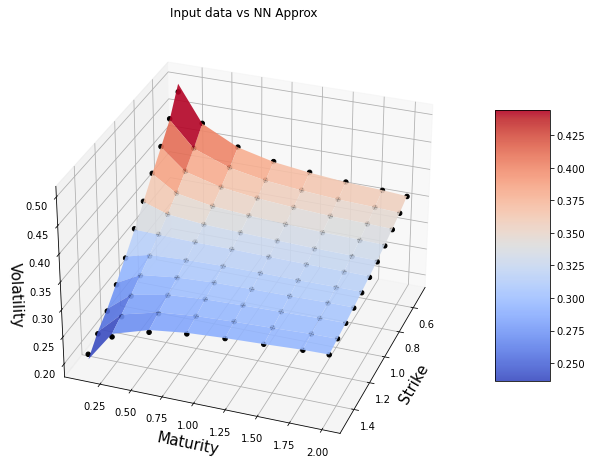

In [16]:
from matplotlib import cm
idx = 2000
X_predict = xinversetransform(NeuralNetwork(y_test_transform))
X_sample =  xinversetransform(x_test_transform)


vola_surf_1 = X_sample[idx]
vola_surf_2 = X_predict[idx]


fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,10))

X_maturities, Y_strikes = np.meshgrid(strikes,maturities)
ax.view_init(30,20)
surf = ax.plot_surface(X_maturities, Y_strikes,vola_surf_1.reshape(maturities_dim,strikes_dim),linewidth=0,alpha = 0.9,cmap=cm.coolwarm, antialiased=True)
ax.scatter(X_maturities, Y_strikes,vola_surf_2.reshape(maturities_dim,strikes_dim),color="k",alpha=1)#,linewidth=10,alpha = 1,cmap=cm.winter, antialiased=True)

ax.set_xlabel("Strike",fontsize=15,labelpad=5)
ax.set_ylabel("Maturity",fontsize=15,labelpad=5)
ax.set_zlabel("Volatility",fontsize=15,labelpad=5)

colBar = fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_title("Input data vs NN Approx")

plt.savefig("CreatedImages/" + model_name + '_volaSurf.png', dpi=300)

plt.show()

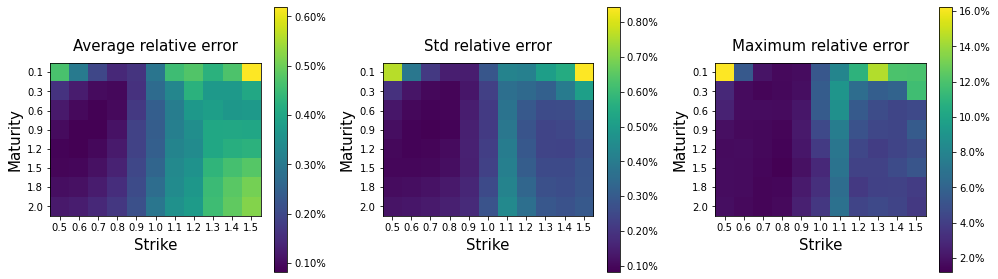

In [17]:
heat_maps(model_1)

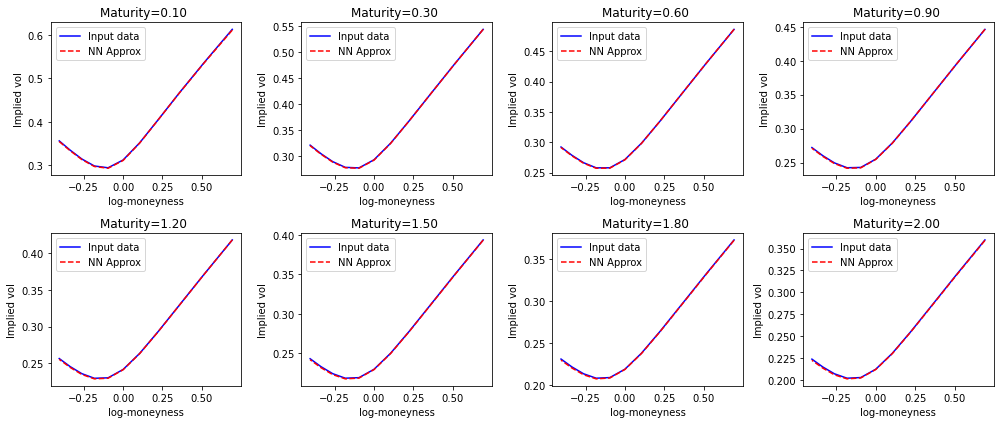

In [18]:
plotCurves(model_1,5000)

## Volatility Calibration

Here, actual volatility calibraiton is performed. 4 different methods are compared, in terms of computaitional time.

In [19]:
import time
import scipy
Approx=[]
Timing=[]

solutions=np.zeros([4,num_params])
times=np.zeros(4)
init=np.zeros(num_params)
for i in range(len(X_test)):
    disp=str(i+1)+"/"+str(len(X_test))
    print (disp,end="\r")
    #L-BFGS-B
    
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='L-BFGS-B',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[0,:]=myinverse(I.x,ub,lb)
    times[0]=end-start
    #SLSQP
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='SLSQP',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[1,:]=myinverse(I.x,ub,lb)
    times[1]=end-start
    #BFGS
    start= time.time()
    I=scipy.optimize.minimize(CostFunc,x0=init,args=i,method='BFGS',jac=Jacobian,tol=1E-10,options={"maxiter":5000})
    end= time.time()
    solutions[2,:]=myinverse(I.x,ub,lb)
    times[2]=end-start
    
    #Levenberg-Marquardt
    start= time.time()
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    end= time.time()
    solutions[3,:]=myinverse(I.x,ub,lb)
    times[3]=end-start
    #I=scipy.optimize.minimize(costfunc,x0=init,method='COBYLA',options={"maxiter":2000})
    #print(I)
    Approx.append(np.copy(solutions))
    Timing.append(np.copy(times))
    #print("Approx ",scale.inverse_transform(I.x))
    #print("True: ",scale.inverse_transform(y_sample))

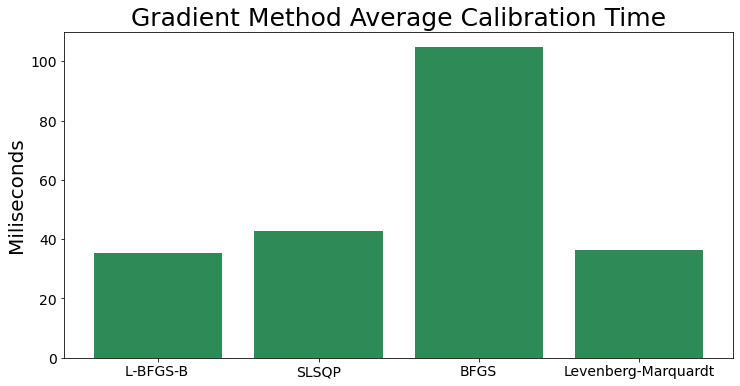

In [20]:
methods=["L-BFGS-B ","SLSQP","BFGS","Levenberg-Marquardt"]
plt.figure(1,figsize=(12,6))
plt.bar(methods,np.mean(Timing,axis=0)*1000, color = 'seagreen')
plt.title("Gradient Method Average Calibration Time",fontsize=25)
plt.ylabel("Miliseconds",fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig('AverageCalibrationTime.png', dpi=300)
plt.show()

In [21]:
sample_ind = len(X_test)
X_sample = X_test[-1]
y_sample = y_test_transform[sample_ind-1]

init=np.zeros(num_params)
I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(sample_ind-1,),gtol=1E-10)

print("Approx ",myinverse(I.x,ub,lb))
print("True: ",myinverse(y_sample,ub,lb))

Approx  [ 0.04524447  3.7566086  -0.70968127  0.06551502]
True:  [ 0.0450708  3.74676   -0.720276   0.0661925]


#### Testing calibration error

In [22]:
LMParameters = []
init=np.zeros(num_params)
for i in range(len(X_test)):
    disp=str(i+1)+"/"+str(len(X_test))
    print (disp,end="\r")
    
    #Levenberg-Marquardt
    I=scipy.optimize.least_squares(CostFuncLS,init, JacobianLS,args=(i,),gtol=1E-10)
    LMParameters.append(myinverse(I.x,ub,lb))

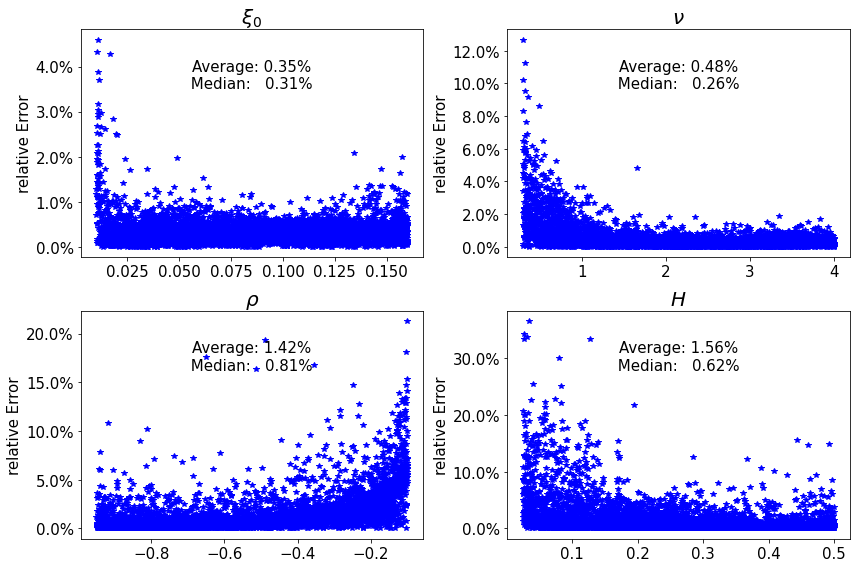

In [23]:
#LMParameters=[Approx[i][3] for i in range(len(Approx))]

titles=["$\\xi_0$","$\\nu$","$\\rho$","$H$"]
average=np.zeros([num_params,len(X_test)])
fig=plt.figure(figsize=(12,8))
for u in range(num_params):
    ax=plt.subplot(2,2,u+1)
    for i in range(len(X_test)):
        
        y=y_test[i][u]
        plt.plot(y,100*np.abs(LMParameters[i][u]-y)/np.abs(y),'b*')
        average[u,i]=np.abs(LMParameters[i][u]-y)/np.abs(y)
    plt.title(titles[u],fontsize=20)
    plt.ylabel('relative Error',fontsize=15)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median:   %1.2f%% '%(np.mean(100*average[u,:]),np.quantile(100*average[u,:],0.5)), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes,fontsize=15)

plt.tight_layout()
plt.savefig('CreatedImages/'+model_name+'ParameterRelativeErrors.png', dpi=300)
plt.show()